C:\UserData\takuyai\Miniconda3\envs\lith_nlp\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


41 Unique LithCodes that are not UNKN or numeric
['GRVL' 'CLAY' 'CRSE' 'SHLE' 'BSLT' 'ROCK' 'SAND' 'SOIL' 'GRNT' 'SASH'
 'CGLM' 'SDSN' 'TPSL' 'BLBN' 'COAL' 'SILT' 'LMSN' 'ALVM' 'QRTZ' 'SDCY'
 'LOAM' 'BLDR' 'SLTE' 'SLCY' 'BNST' 'VLCC' 'SLSN' 'BRBN' 'GRBN' 'MDSN'
 'WB' 'TUFF' 'BDRK' 'SNDY' 'SDMN' 'CVTY' 'CLBD' 'FILL' 'DLMT' 'WODY'
 'FINE']
Attempting to fill in 99 unknown MajorLithCode based on provided descriptions


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:33<00:00,  2.92it/s]


After clean up 40 unique LithCodes that are not UNKN or numeric
['GRVL' 'CLAY' 'CRSE' 'SHLE' 'BSLT' 'ROCK' 'SAND' 'SOIL' 'TPSL' 'GRNT'
 'SASH' 'CGLM' 'SDSN' 'COAL' 'SILT' 'LMSN' 'ALVM' 'QRTZ' 'SDCY' 'LOAM'
 'BLDR' 'SLTE' 'SLCY' 'VLCC' 'SLSN' 'BRBN' 'GRBN' 'MDSN' 'WB' 'TUFF'
 'BDRK' 'SNDY' 'SDMN' 'CVTY' 'CLBD' 'FILL' 'DLMT' 'WODY' 'BNST' 'FINE']
(1000,) (1000,)
Number of entries 1000
Dictionary(139 unique tokens: ['bear', 'cement', 'gravel', 'water', 'clay']...)


notebook_setup.ipynb:6: UserWarning: WARNING - Filtering to unique LithCode and Description, which may not be desirable in future!
  "metadata": {},


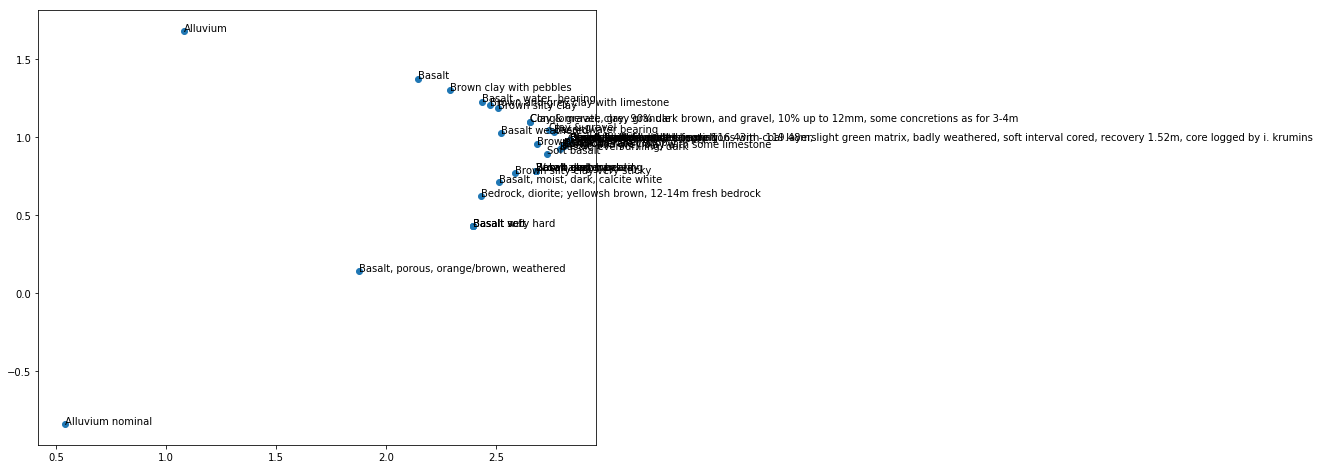

If using amalgamated example dataset, this should be around 560 entries: 560


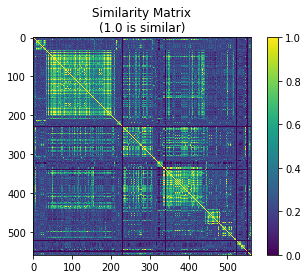

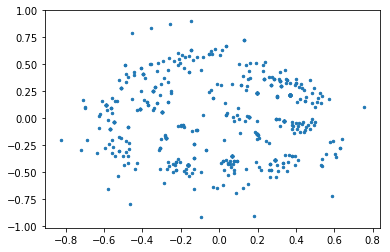

Num clusters: 67


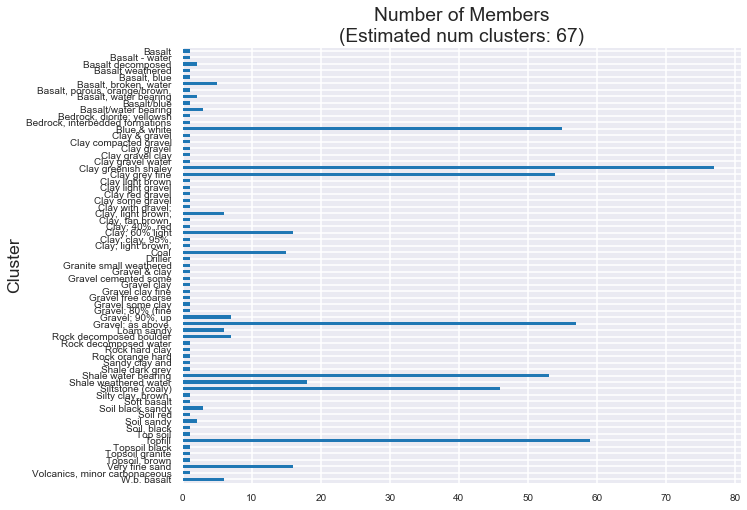

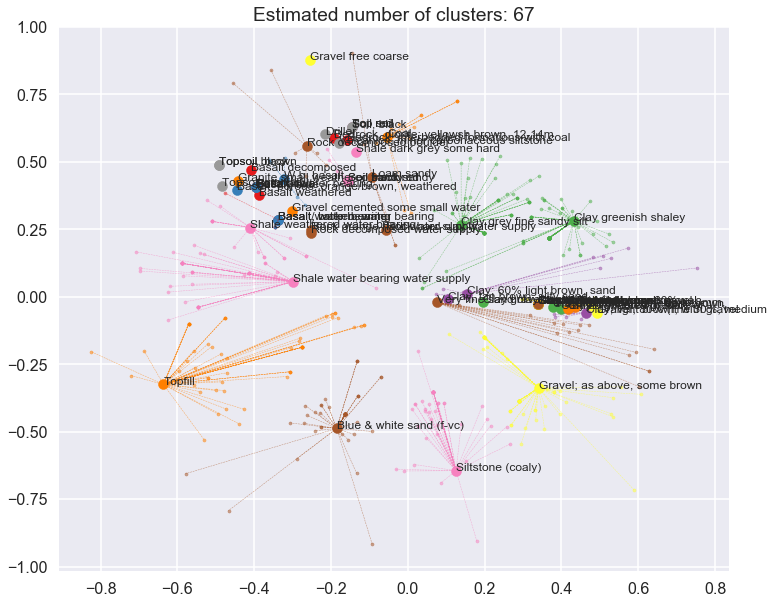

In [1]:
%run "Lith Affinity Prop.ipynb"

# The above runs the notebook setup as well

# Let's try HDBScan

Useful links
* http://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/How%20HDBSCAN%20Works.ipynb
* http://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html

Text(0.5,1,'Similarity matrix\n(1.0 is similar)')

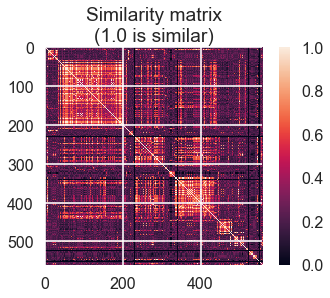

In [2]:
plt.imshow(token_sim)
plt.colorbar()
plt.title("Similarity matrix\n(1.0 is similar)")

In [54]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=2)
pos = mds.fit_transform(1 - token_sim)

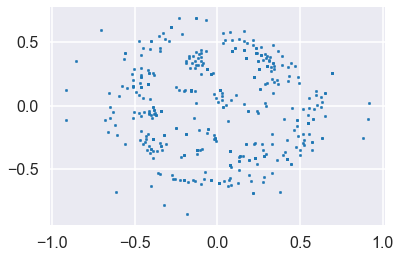

In [55]:
plt.scatter(pos[:, 0], pos[:, 1], s=6)

In [76]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=4, gen_min_span_tree=True)
clusterer.fit(pos)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=2, min_samples=4, p=None,
    prediction_data=False)

In [77]:
# ?hdbscan.HDBSCAN

In [78]:
import seaborn as sns
sns.set_context('poster')
sns.set_style('darkgrid')
sns.set_color_codes()

In [79]:
# cluster_centers_indices = clusterer.exemplars_ # Library limitation: cannot get exemplars at the moment
labels = clusterer.labels_
cluster_centers_idx = np.unique(labels)
unique_labels = np.unique(labels)
n_clusters_ = len(cluster_centers_idx)

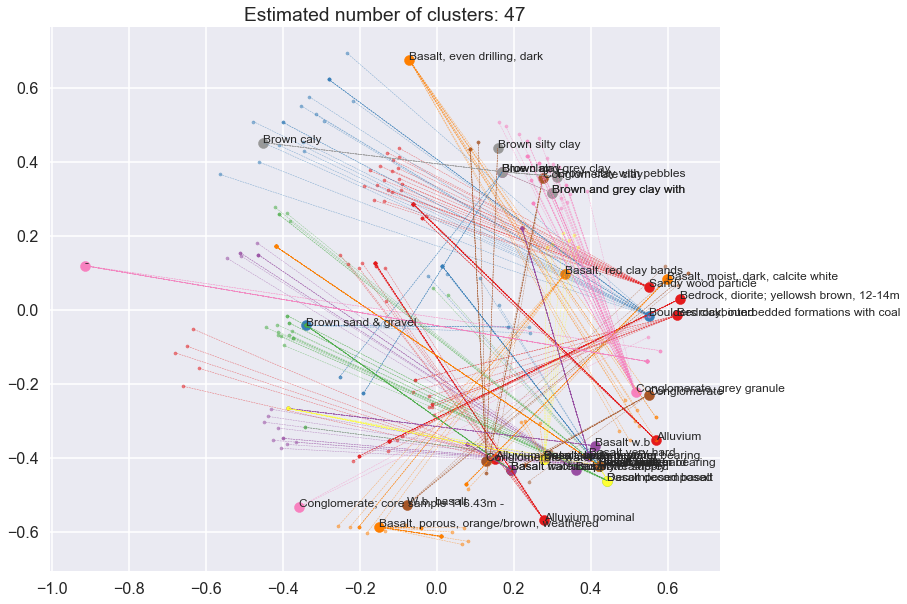

In [80]:
fig, ax = plt.subplots(figsize=(12,10))

cm = plt.get_cmap('Set1')
colors = [cm(1.0*i/n_clusters_) for i in range(n_clusters_)]

count = 0
# for each cluster get all members and plot with same color
for cluster_idx, color in zip(range(n_clusters_), colors):
    in_cluster = labels == cluster_idx
    cluster_set = pos[in_cluster]
    
    cluster_row = cluster_centers_idx[cluster_idx]
    cluster_center = pos[cluster_row]
    
    exemplar = lith_desc.iat[cluster_row]
    
    # Plot cluster exemplar
    ax.scatter(cluster_center[0], cluster_center[1], marker='o', c=color, s=100)
    ax.annotate(" ".join(exemplar.split()[:5]), (cluster_center[0], cluster_center[1]), alpha=1, fontsize=12)
    
    for i, txt in enumerate(lith_desc[in_cluster]):
        if txt == exemplar:
            continue
            
        x, y = cluster_set[i]
        
        # Plot cluster member
        ax.scatter(x, y, marker='o', c=color, alpha=0.5, s=10)
        
        # Plot line between cluster exemplar and member
        plt.plot([cluster_center[0], x], [cluster_center[1], y], c=color, 
                 linestyle='--', linewidth=0.5, alpha=0.6)
    # End for
    
# End for

plt.title(f"Estimated number of clusters: {n_clusters_}");


In [81]:
# TODO Move all this into functions

# Write out results to csv
res = {}

for cluster_id in unique_labels:
    cluster = cluster_centers_idx[cluster_id]
    if cluster == -1:
        exemplar = "No cluster"
    else:
        exemplar = lith_desc[cluster_centers_idx[cluster_id]]
    cluster = np.unique(lith_desc[np.nonzero(labels == cluster_id)[0]])
    res[exemplar] = " | ".join(cluster)
# End for

res_df = pd.DataFrame([i for i in res.values()], index=res.keys(), columns=["Matches"])
res_df.index.name = "Exemplar"

try:
    res_df.to_csv("hdbscan_eg_output.csv", index=True)
except PermissionError:
    raise PermissionError("ERROR OCCURRED - csv file is probably open in Excel. Close Excel and try again.")
# End try

assert len(unique_labels) == len(res_df.index), "Number of clusters do not match outputted cluster exemplars!"